## CNN Transfer Learning on Cats-Dogs Classification - Fine Tune - Solution

#### Finetune MobileNet-V2 top layers and classification layers to classify cats vs. dogs.
Adapted from https://www.tensorflow.org/tutorials/images/transfer_learning

### CIML Summer Institute
UC San Diego

-----

### Setup

In [1]:
# Set logging level
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

In [3]:
print (tf.__version__)
!python --version

2.15.1
Python 3.10.12


In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
!nvidia-smi

Tue Jun 25 11:58:32 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   33C    P0    41W / 300W |      3MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Set random generator seed
seed = 1234

# Set Python seed, NumPy seed, and TensorFlow seed
tf.keras.utils.set_random_seed(seed)

# Potential randomness from CUDNN
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'

### Set image location and dimensions

In [7]:
import os 

from os.path import expanduser
HOME = expanduser("~")
data_path = HOME + '/data/catsVsDogs'
print (data_path)

# Location of images
train_data_dir = data_path + '/train'
val_data_dir   = data_path + '/val'
test_data_dir  = data_path + '/test'

print ('Train path:' + train_data_dir)
print ('Validation path:' + val_data_dir)
print ('Test path:' + test_data_dir)

/home/train109/data/catsVsDogs
Train path:/home/train109/data/catsVsDogs/train
Validation path:/home/train109/data/catsVsDogs/val
Test path:/home/train109/data/catsVsDogs/test


In [8]:
# Image dimensions
img_width, img_height = 224, 224 
IMG_SIZE = (img_width,img_height)
IMG_SHAPE = IMG_SIZE + (3,)

# Print image shape
print(IMG_SHAPE)

### Prepare data

In [9]:
# Batch size
BATCH_SIZE = 16

# Data setup
rescale = tf.keras.applications.mobilenet_v2.preprocess_input
train_datagen      = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, preprocessing_function = rescale)
validation_datagen = ImageDataGenerator(preprocessing_function = rescale)
test_datagen       = ImageDataGenerator(preprocessing_function = rescale)

# Set up generator to read images found in subfolders of training data directory,
# and indefinitely generate batches of image data (scaled).  This is for training data.
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='binary', 
    shuffle = True,
    seed = seed)           

# Set up generator to generate batched of validation data for model
validation_generator = validation_datagen.flow_from_directory(
    val_data_dir,
    target_size=IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='binary',
    shuffle = False, 
    seed = seed)

# Set up generator to generate batched of test data for model
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='binary',
    shuffle = False,
    seed = seed)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### Load model from feature extraction
Load model saved from feature extraction.  Weights in last blocks and top model will be adjusted.  All other weights are frozen.

In [10]:
model = tf.keras.models.load_model('models/features_model')

In [11]:
# Uncomment to list layers in model
# print("Number of layers in the base model: ", len(model.layers[1].layers))
# list(enumerate(model.layers[1].layers))

In [12]:
## Freeze all weights of model up to Block 14
model.trainable = True
fine_tune_start = 116
for layer in model.layers[1].layers[:fine_tune_start]:
    layer.trainable = False
    
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1682625 (6.

### Fine tune model

In [13]:
EPOCHS = 20

# Compile model with very slow learning rate
model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    loss = losses.BinaryCrossentropy(),
    metrics = ['accuracy'])

# Perform early stopping to avoid overfitting and ModelCheckpoint to save the best model
checkpoint_path = 'tmp/checkpoint'
callbacks = [
    EarlyStopping(
        monitor = 'val_loss', 
        patience = 3, 
        min_delta = 0.001, 
        mode = 'min'),
    ModelCheckpoint(
        filepath=checkpoint_path, 
        monitor = 'val_loss', 
        mode = 'min',          
        save_best_only = True, 
        save_weights_only = True)]

In [14]:
%%time

train_history = model.fit(
    train_generator,
    epochs = EPOCHS, 
    validation_data = validation_generator, 
    callbacks = callbacks)

Epoch 1/20


I0000 00:00:1719341926.497277  727130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 27s 140ms/step - loss: 0.2582 - accuracy: 0.8945 - val_loss: 0.0823 - val_accuracy: 0.9700
Epoch 2/20
125/125 [==============================] - 17s 134ms/step - loss: 0.1374 - accuracy: 0.9545 - val_loss: 0.0687 - val_accuracy: 0.9775
Epoch 3/20
125/125 [==============================] - 17s 133ms/step - loss: 0.1073 - accuracy: 0.9655 - val_loss: 0.0571 - val_accuracy: 0.9775
Epoch 4/20
125/125 [==============================] - 17s 134ms/step - loss: 0.1064 - accuracy: 0.9615 - val_loss: 0.0479 - val_accuracy: 0.9850
Epoch 5/20
125/125 [==============================] - 16s 130ms/step - loss: 0.0774 - accuracy: 0.9725 - val_loss: 0.0481 - val_accuracy: 0.9850
Epoch 6/20
125/125 [==============================] - 17s 134ms/step - loss: 0.0714 - accuracy: 0.9780 - val_loss: 0.0449 - val_accuracy: 0.9850
Epoch 7/20
125/125 [==============================] - 16s 130ms/step - loss: 0.0650 - accuracy: 0.9745 - val_loss: 0.0456 - val_accuracy: 0.9

In [15]:
# Load the best model that was saved using ModelCheckpoint
model.load_weights(checkpoint_path)

In [16]:
# Save weights from finetuning
model.save("models/finetune_model")

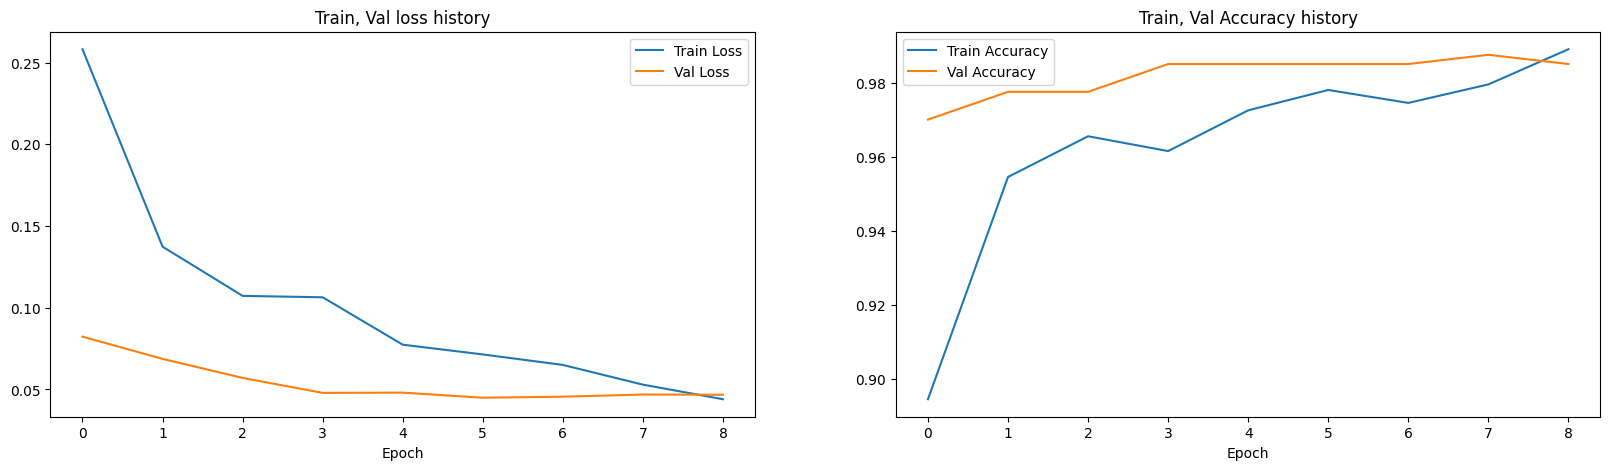

In [17]:
# Plot train and validation loss
fig, axs = plt.subplots(1,2, figsize= (20,5))
axs[0].plot(train_history.history['loss'])
axs[0].plot(train_history.history['val_loss'])
axs[0].set_title("Train, Val loss history")
axs[0].set_xlabel("Epoch")
axs[0].legend(["Train Loss","Val Loss"])

# Plot train and validation accuracy
axs[1].plot(train_history.history['accuracy'])
axs[1].plot(train_history.history['val_accuracy'])
axs[1].set_title("Train, Val Accuracy history")
axs[1].set_xlabel("Epoch")
axs[1].legend(["Train Accuracy","Val Accuracy"])

### Evaluate model

In [18]:
_, train_accuracy = model.evaluate(train_generator)
print("Train data accuracy:", train_accuracy)

_, test_accuracy = model.evaluate(test_generator)
print("Test data accuracy:", test_accuracy)

125/125 [==============================] - 16s 127ms/step - loss: 0.0190 - accuracy: 0.9960
Train data accuracy: 0.9959999918937683
25/25 [==============================] - 1s 24ms/step - loss: 0.0327 - accuracy: 0.9925
Test data accuracy: 0.9925000071525574


In [19]:
# Get predicted value and the ground truth value of test data
pred = (model.predict(test_generator) > 0.5).astype("int32")
true = test_generator.classes

25/25 [==============================] - 1s 23ms/step


In [20]:
# Get evaluation metrics for test data
print(classification_report(y_true= true, y_pred = pred, target_names=['cats', 'dogs'], digits=4))

              precision    recall  f1-score   support

        cats     0.9900    0.9950    0.9925       200
        dogs     0.9950    0.9900    0.9925       200

    accuracy                         0.9925       400
   macro avg     0.9925    0.9925    0.9925       400
weighted avg     0.9925    0.9925    0.9925       400



### Perform inference on test images

In [21]:
def image_loader(img_file):
    """load individual images"""
    img = load_img(img_file, target_size = (img_width, img_height))
    imgplot = plt.imshow(img)
    plt.show()
    img = (img_to_array(img)/127.5)-1.0
    img = np.expand_dims(img, axis = 0) #model input is (1,150,150,3)
    return img

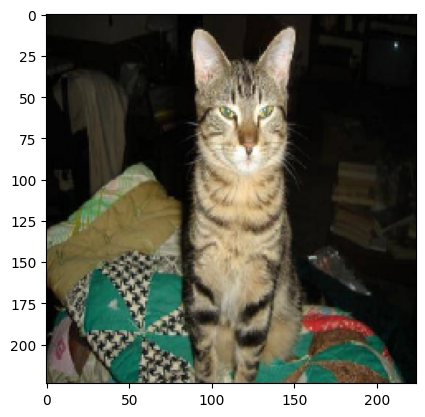

1/1 [==============================] - 1s 626ms/step
[[0.00137]]


In [22]:
test_image = data_path + '/test/cats/cat.1070.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

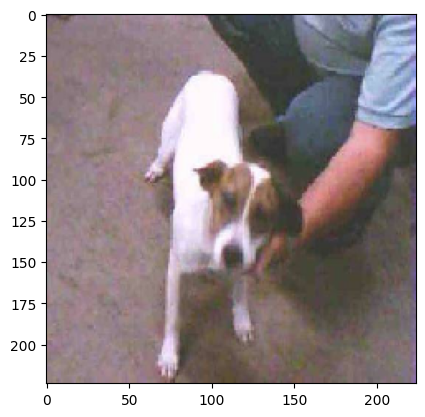

1/1 [==============================] - 0s 20ms/step
[[0.9999]]


In [23]:
test_image = data_path + '/test/dogs/dog.1233.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

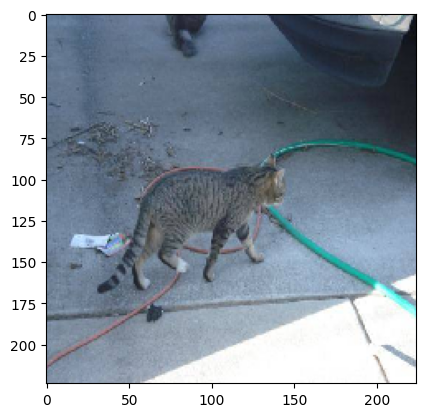

1/1 [==============================] - 0s 19ms/step
[[0.12287]]


In [24]:
test_image = data_path + '/test/cats/cat.1080.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

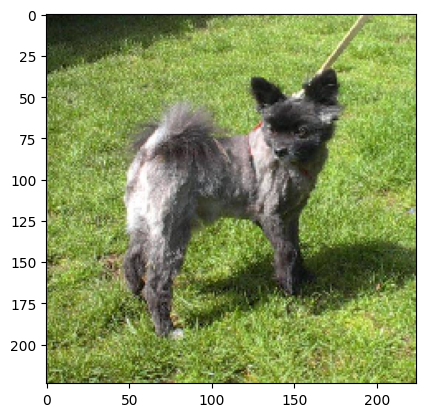

1/1 [==============================] - 0s 19ms/step
[[0.90075]]


In [25]:
test_image = data_path + '/test/dogs/dog.1132.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

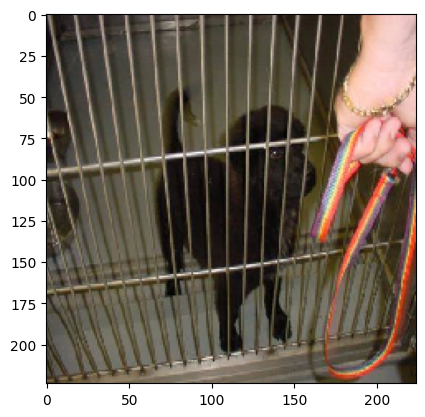

1/1 [==============================] - 0s 18ms/step
[[0.12058]]


In [26]:
test_image = data_path + '/test/dogs/dog.1311.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

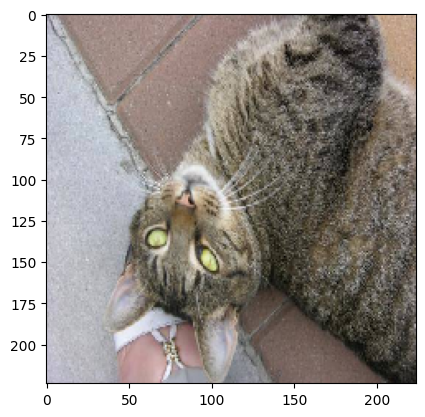

1/1 [==============================] - 0s 18ms/step
[[0.01277]]


In [27]:
test_image = data_path + '/test/cats/cat.1338.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

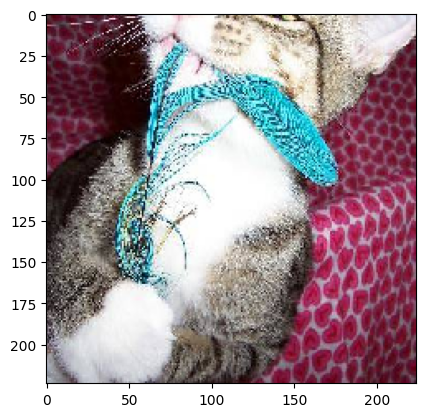

1/1 [==============================] - 0s 18ms/step
[[0.05297039]]


In [28]:
test_image = data_path + '/test/cats/cat.1342.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(img_y_pred)

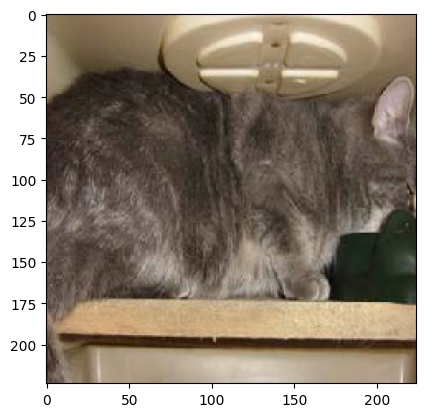

1/1 [==============================] - 0s 18ms/step
[[0.0002]]


In [29]:
test_image = data_path + '/test/cats/cat.1180.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

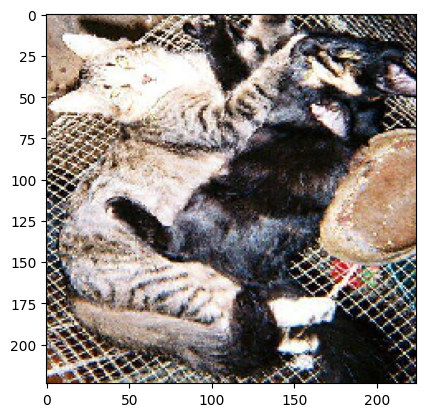

1/1 [==============================] - 0s 18ms/step
[[0.12581]]


In [30]:
test_image = data_path + '/test/cats/cat.1048.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

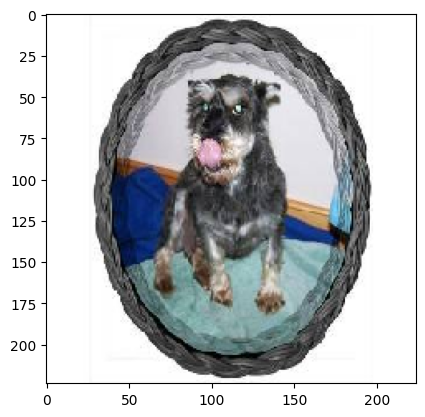

1/1 [==============================] - 0s 18ms/step
[[0.99836]]


In [31]:
test_image = data_path + '/test/dogs/dog.1342.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

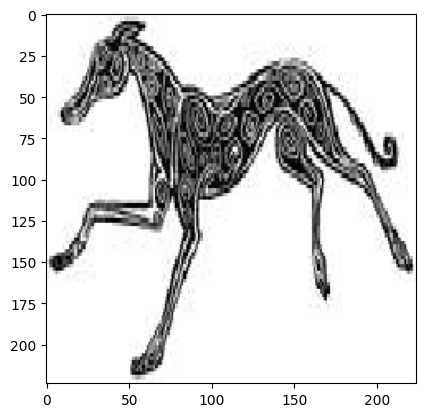

1/1 [==============================] - 0s 18ms/step
[[0.65327]]


In [32]:
test_image = data_path + '/test/dogs/dog.1308.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))